In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('PRM_L2.csv')
# transform date to season
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data['Season'] = np.where(
    data['Date'].dt.month >= 8,
    data['Date'].dt.year.astype(str) + "/" + (data['Date'].dt.year + 1).astype(str),
    (data['Date'].dt.year - 1).astype(str) + "/" + data['Date'].dt.year.astype(str)
)
data.drop(['Date'], axis=1, inplace=True)
data.dropna()

def b365_odds_to_probability(odds):
    
    probability = 1 / odds if odds > 1 else 1 - odds
    return probability

leagues = data['Level'].unique()
data


,Level,Hour,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
0,PRM,20:00,Liverpool,Norwich,4,1,H,4,0,H,...,11,2,0,2,0,0,1.14,10.00,19.00,2019/2020
1,PRM,12:30,West Ham,Man City,0,5,A,0,1,A,...,1,1,2,2,0,0,12.00,6.50,1.22,2019/2020
2,PRM,15:00,Bournemouth,Sheffield United,1,1,D,0,0,D,...,3,4,2,1,0,0,1.95,3.60,3.60,2019/2020
3,PRM,15:00,Burnley,Southampton,3,0,H,0,0,D,...,2,7,0,0,0,0,2.62,3.20,2.75,2019/2020
4,PRM,15:00,Crystal Palace,Everton,0,0,D,0,0,D,...,6,2,2,1,0,1,3.00,3.25,2.37,2019/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7875,L2,12:30,Stockport,Hartlepool,1,1,D,1,0,H,...,9,1,0,1,0,0,1.20,6.50,15.00,2022/2023
7876,L2,12:30,Sutton,Carlisle,1,1,D,1,0,H,...,5,2,0,1,0,0,3.40,3.40,2.15,2022/2023
7877,L2,12:30,Swindon,Crawley Town,2,1,H,2,0,H,...,7,3,1,2,0,0,1.80,3.80,4.33,2022/2023
7878,L2,12:30,Tranmere,Northampton,0,1,A,0,1,A,...,9,8,1,1,0,0,5.25,3.80,1.67,2022/2023


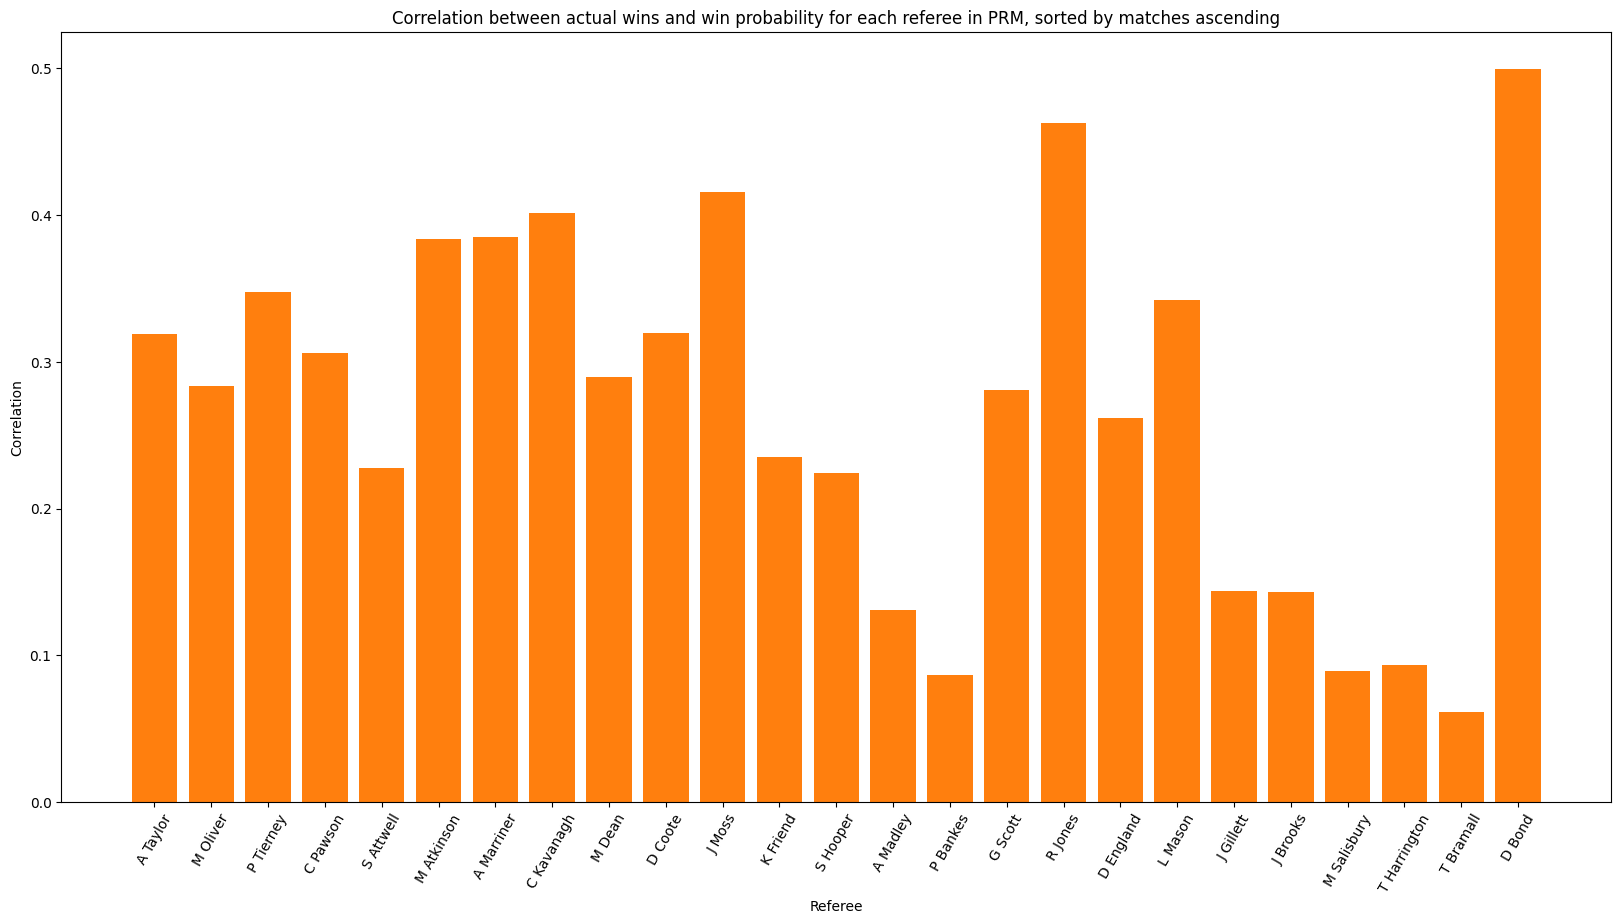

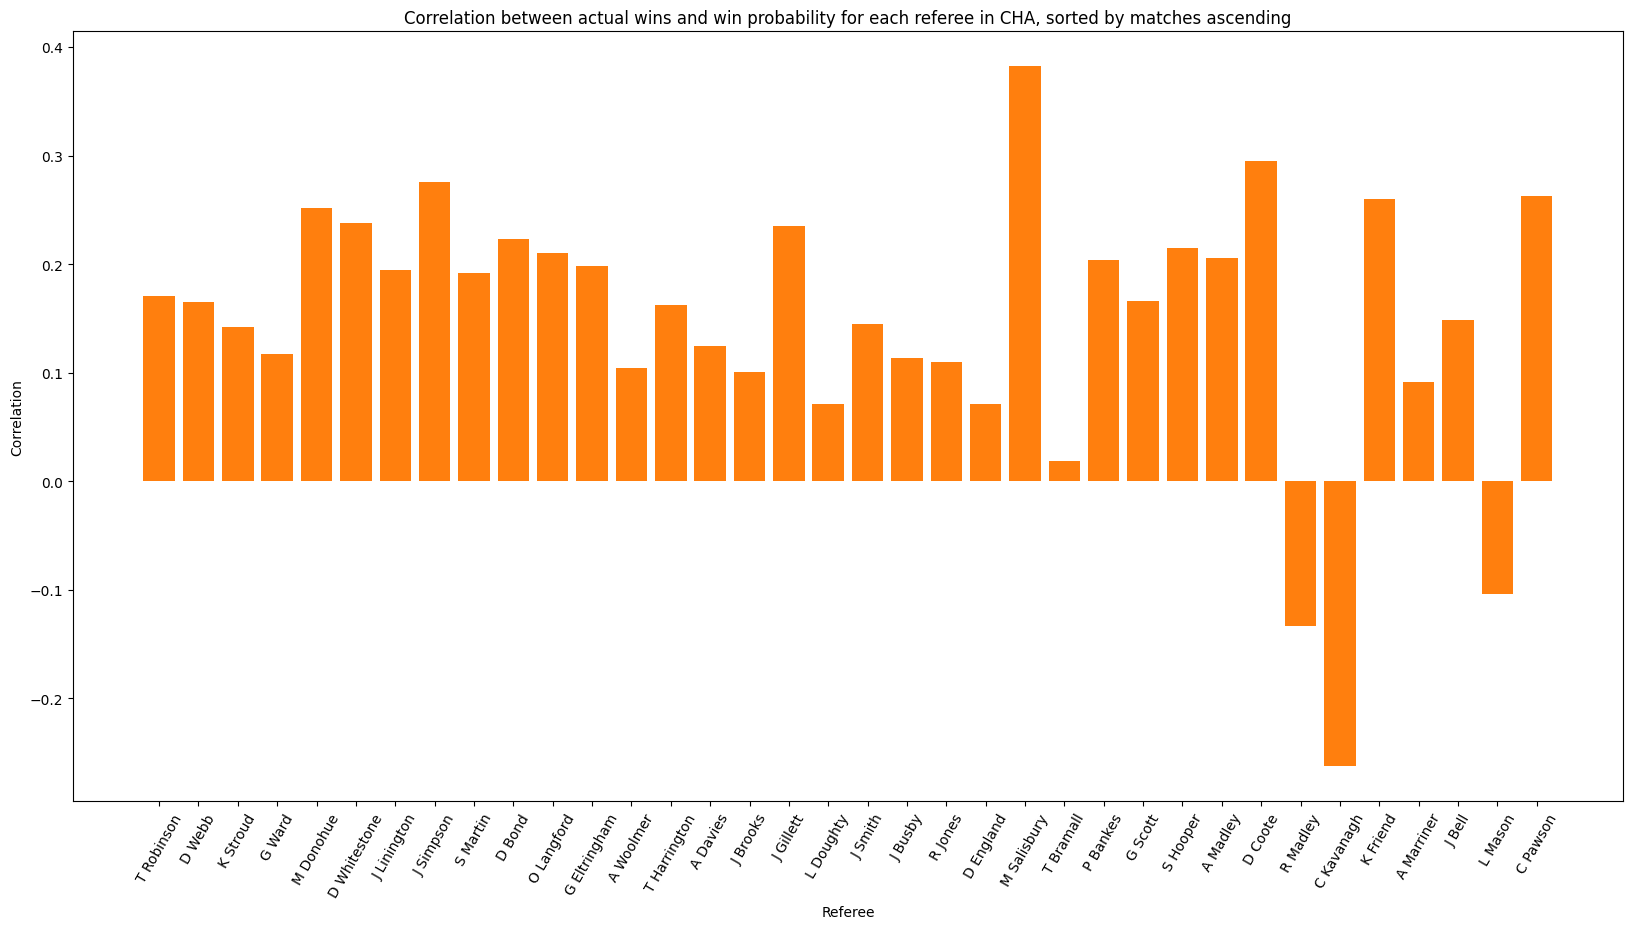

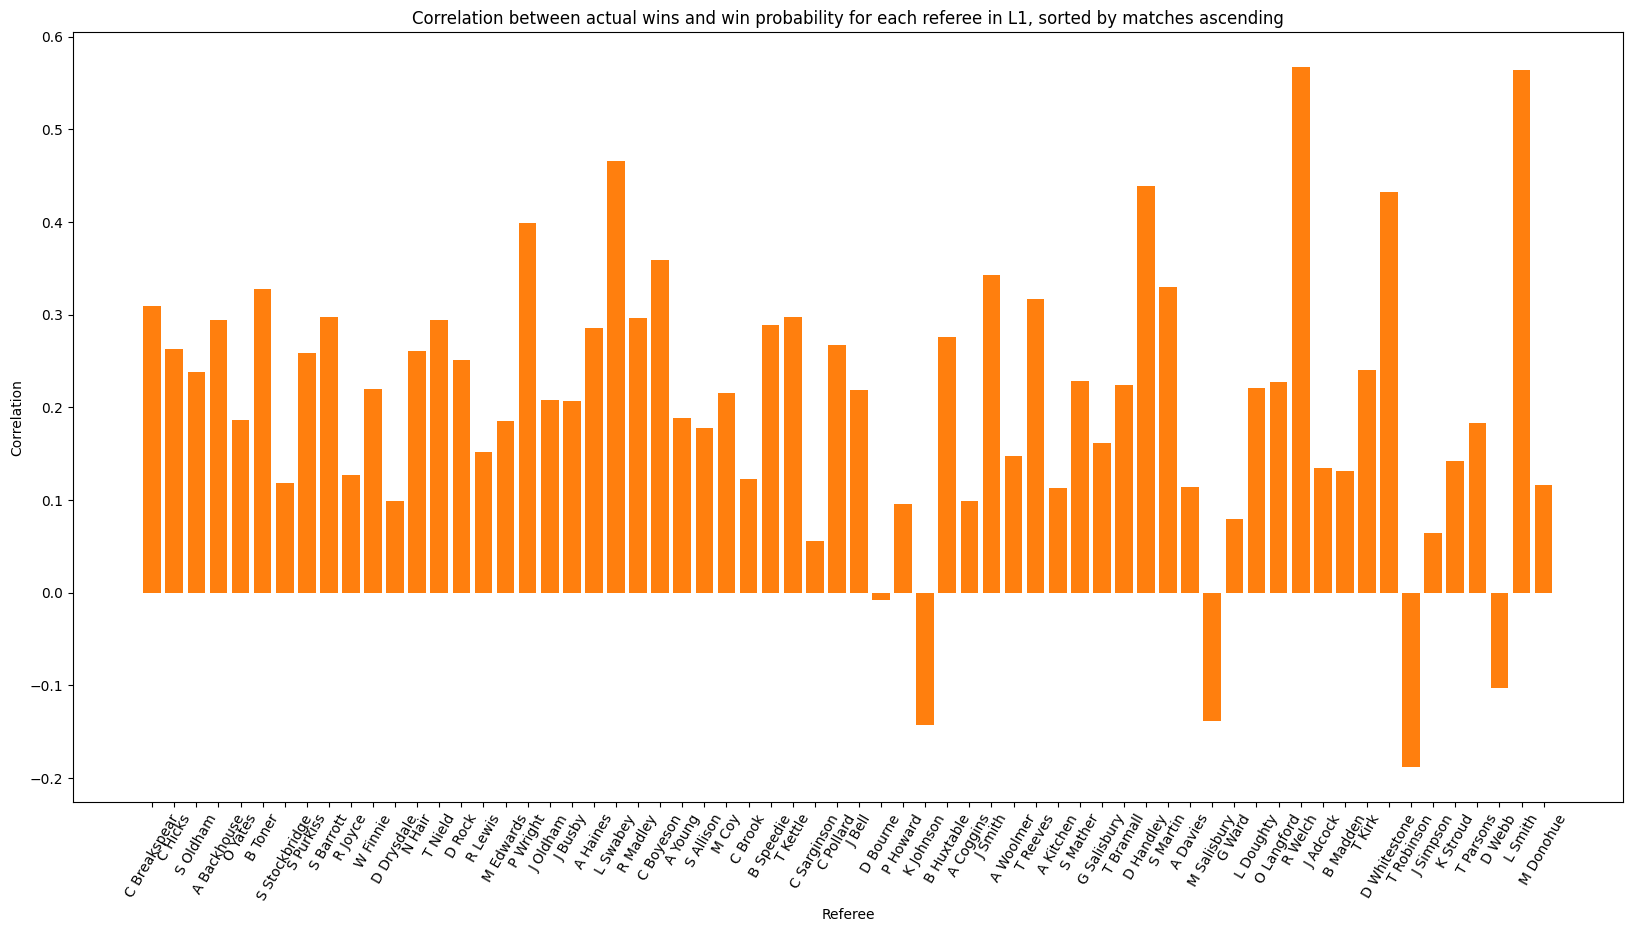

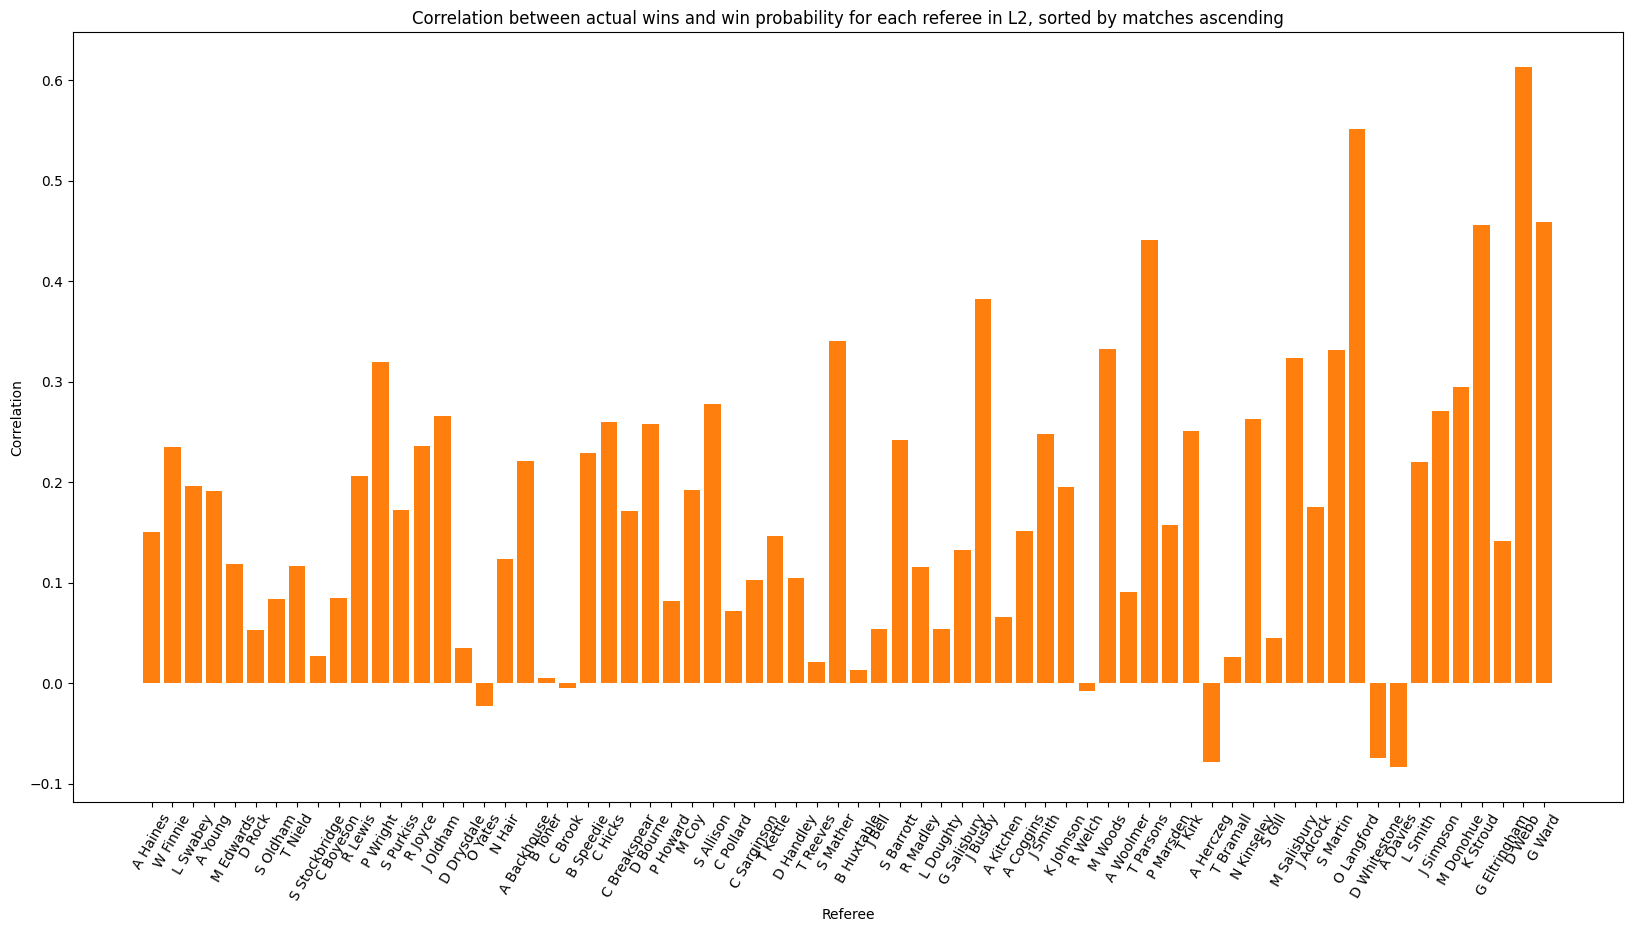

In [200]:
groupedreferees = dane.groupby('Referee')
referees = {name: referee for name, referee in groupedreferees if len(referee) > 0}

for i, referee in enumerate(referees):
    referees[referee]['B365H_prob'] = referees[referee]['B365H'].apply(b365_odds_to_probability)
    referees[referee]['B365D_prob'] = referees[referee]['B365D'].apply(b365_odds_to_probability)
    referees[referee]['B365A_prob'] = referees[referee]['B365A'].apply(b365_odds_to_probability)

seasonal_data = {}

for season in data['Season'].unique():
    league_referees_corr = {}

    for league in leagues:
        league_referees_corr[league] = pd.DataFrame(index=referees.keys(), columns=['matches', 'home_corr', 'draw_corr', 'away_corr', 'mean_corr'])

    # calculate correlation between actual wins and win  where referees are indexes and columns are home_corr, draw_corr and away_corr
    for league in leagues:
        for i, referee in enumerate(referees):
            league_referees_corr[league].loc[referee, 'matches'] = len(referees[referee][referees[referee]['Level'] == league])
            league_referees_corr[league].loc[referee, 'home_corr'] = referees[referee][referees[referee]['Level'] == league]['B365H_prob'].corr(referees[referee][referees[referee]['Level'] == league]['FTR'] == 'H')
            league_referees_corr[league].loc[referee, 'draw_corr'] = referees[referee][referees[referee]['Level'] == league]['B365D_prob'].corr(referees[referee][referees[referee]['Level'] == league]['FTR'] == 'D')
            league_referees_corr[league].loc[referee, 'away_corr'] = referees[referee][referees[referee]['Level'] == league]['B365A_prob'].corr(referees[referee][referees[referee]['Level'] == league]['FTR'] == 'A')
        league_referees_corr[league]['mean_corr'] = league_referees_corr[league][['home_corr', 'draw_corr', 'away_corr']].mean(axis=1)
        league_referees_corr[league].sort_values(by='mean_corr', inplace=True, ascending=False)
    for league in leagues:
        league_referees_corr[league].dropna(inplace=True)
        league_referees_corr[league].to_csv('referees_corr_{}.csv'.format(league))

    PRM_referees = league_referees_corr['PRM'].index
    for league in leagues:
        #league_referees_corr[league] = league_referees_corr[league].loc[league_referees_corr[league].index.intersection(PRM_referees)]
        league_referees_corr[league].sort_values(by='matches', inplace=True, ascending=False)

    seasonal_data[season] = league_referees_corr

# plot correlation between actual wins and win probability for each referee
for league in leagues:
    plt.figure(figsize=(20, 10))
    plt.title('Correlation between actual wins and win probability for each referee in {}, sorted by matches ascending'.format(league))
    plt.xlabel('Referee')
    plt.ylabel('Correlation')
    #plt.bar(league_referees_corr[league].index, league_referees_corr[league]['mean_corr'])
    plt.bar(seasonal_data['2019/2020'][league].index, seasonal_data['2019/2020'][league]['mean_corr'])
    plt.xticks(rotation=60)
    plt.show()